In [16]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Electrical Measurement Data Analysis

## Dataset Overview
- **File**: AKB40-M.wav.19.28.27.79.dat
- **Date**: 09-20-2006, 19.28.27.79
- **Sample**: AKB40-M
- **Device**: #21
- **Measurement Type**: Electrical characterization (Isd vs Vsd)
- **File Size**: ~400KB
- **Data Points**: ~50,000 measurements

This appears to be semiconductor device characterization data, measuring source-drain current (Isd) versus source-drain voltage (Vsd).

## Data Description

### Experimental Setup
- **Measurement Type**: Current vs Time at 50kHz sampling rate
- **Duration**: Extended time series with distinct phases
- **File Format**: Compressed binary format designed for LabVIEW

### Experimental Phases
1. **Background Period** (~first 15 minutes)
   - Baseline measurements before molecule introduction
   - Used for background subtraction and noise characterization

2. **Molecule Introduction**
   - Small wire molecule sometimes gets attached to the system
   - Creates measurable changes in current

3. **Active/Reactive Model**
   - Step function behavior observed: up → down → up → down
   - Followed by waiting periods between reactions
   - Indicates molecular binding/unbinding events

### Analysis Goals
- **Identify Background**: Characterize the first 15 minutes of baseline data
- **Detect Molecule Introduction**: Find when small molecule attachment occurs  
- **Classify Periods**: Distinguish between "active period" and "inactive period"
- **Model Step Functions**: Analyze the up-down-up-down reactive patterns

In [2]:
# Inspect the Data folder contents
!ls  Data/

AKB40-M.wav.19.28.27.79.dat


In [3]:
# Examine the raw file structure using hexdump
!hexdump -C Data/AKB40-M.wav.19.28.27.79.dat | head -20

00000000  55 73 65 72 20 4e 61 6d  65 3a 20 09 6a 63 0d 0a  |User Name: .jc..|
00000010  44 61 74 65 2c 20 54 69  6d 65 20 62 65 67 75 6e  |Date, Time begun|
00000020  3a 20 09 30 39 2d 32 30  2d 32 30 30 36 2c 20 20  |: .09-20-2006,  |
00000030  31 39 2e 32 38 2e 32 37  2e 37 39 0d 0a 53 61 6d  |19.28.27.79..Sam|
00000040  70 6c 65 20 4e 61 6d 65  3a 20 09 41 4b 42 34 30  |ple Name: .AKB40|
00000050  2d 4d 0d 0a 44 65 76 69  63 65 23 3a 09 32 31 0d  |-M..Device#:.21.|
00000060  0a 50 72 6f 62 65 73 3a  09 44 45 0d 0a 53 61 6d  |.Probes:.DE..Sam|
00000070  70 6c 65 20 44 65 73 63  72 69 70 74 69 6f 6e 3a  |ple Description:|
00000080  20 09 45 44 43 2f 4e 48  53 0d 0a 4d 65 61 73 75  | .EDC/NHS..Measu|
00000090  72 65 6d 65 6e 74 20 43  6f 6d 6d 65 6e 74 73 3a  |rement Comments:|
000000a0  20 20 09 0d 0a 54 68 65  72 6d 6f 6d 65 74 72 79  |  ...Thermometry|
000000b0  3a 20 09 0d 0a 0d 23 23  0d 32 20 32 0d 0a 0d 49  |: ....##.2 2...I|
000000c0  73 64 09 56 73 64 0d 0a  33 11 7a 10 3d c3

In [8]:
# Select which data file to analyze
# TODO: Change this filename to the file you want to analyze
filename = "AKB40-M.wav.19.28.27.79.dat"
file_path = f"Data/{filename}"

print(f"Selected file: {filename}")
print(f"Full path: {file_path}")

Selected file: AKB40-M.wav.19.28.27.79.dat
Full path: Data/AKB40-M.wav.19.28.27.79.dat


In [9]:
# Extract and display the header data
with open(file_path, "rb") as f:
    content = f.read()

# Find where the header ends (at the "Isd\tVsd" marker)
marker = b"Isd\tVsd"
header_end = content.find(marker)

if header_end != -1:
    # Extract header text (everything before the marker)
    header_data = content[:header_end].decode('utf-8', errors='ignore')
    print("=== FILE HEADER ===")
    print(header_data)
    print(f"\n=== HEADER INFO ===")
    print(f"Header length: {header_end} bytes")
    print(f"Data marker found at position: {header_end}")
else:
    print("Marker 'Isd\\tVsd' not found!")

=== FILE HEADER ===
User Name: 	jc
Date, Time begun: 	09-20-2006,  19.28.27.79
Sample Name: 	AKB40-M
Device#:	21
Probes:	DE
Sample Description: 	EDC/NHS
Measurement Comments:  	
Thermometry: 	
2 2


=== HEADER INFO ===
Header length: 191 bytes
Data marker found at position: 191


In [14]:
# Load the binary data into pandas DataFrame

with open(file_path, "rb") as f:
    raw = f.read()

offset = 201  # where binary starts

# Calculate the length of the binary data after the offset
trim_len = len(raw) - offset

# Trim the buffer to a multiple of 8 bytes (2 float32 per row)
trimmed = raw[offset:offset + (trim_len - (trim_len % 8))]

# Read as little-endian float32 and reshape into 2 columns
data_array = np.frombuffer(trimmed, dtype="<f4").reshape(-1, 2)

# Create pandas DataFrame
data_1 = pd.DataFrame(data_array, columns=['Isd', 'Vsd'])

print(f"Data loaded successfully!")
print(f"DataFrame shape: {data_1.shape}")
print(f"Data types: {data_1.dtypes}")
print(f"\nFirst few rows:")
data_1.head()

Data loaded successfully!
DataFrame shape: (50000, 2)
Data types: Isd    float32
Vsd    float32
dtype: object

First few rows:


,Isd,Vsd
0,0.035273,2.994853e-08
1,0.094084,2.997765e-08
2,0.098187,2.991944e-08
3,0.036234,2.986123e-08
4,0.035158,2.991944e-08


## Exploratory Data Analysis (EDA)

Now let's explore the data to understand its characteristics and identify the different experimental phases.

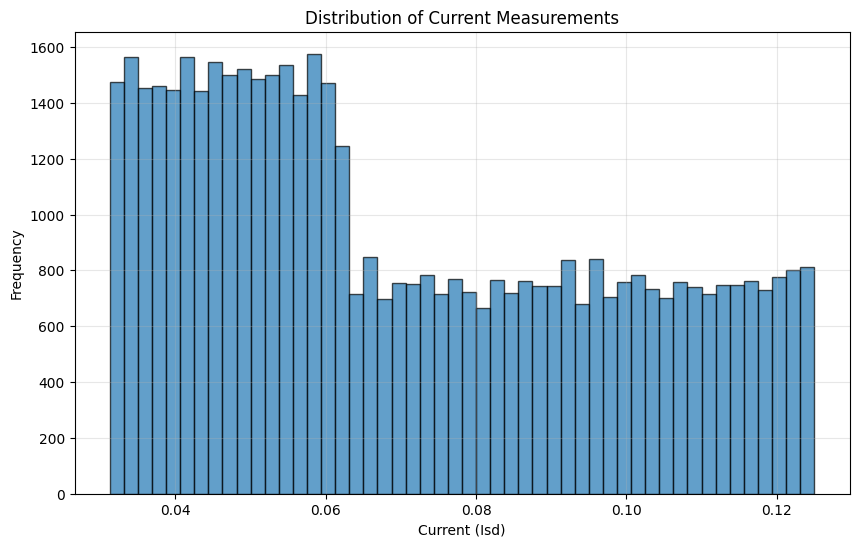

Current (Isd) Statistics:
count    50000.000000
mean         0.070424
std          0.027505
min          0.031260
25%          0.046920
50%          0.062591
75%          0.093882
max          0.124983
Name: Isd, dtype: float64


In [17]:
# Histogram of current (Isd) values
plt.figure(figsize=(10, 6))
plt.hist(data_1['Isd'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Current (Isd)')
plt.ylabel('Frequency')
plt.title('Distribution of Current Measurements')
plt.grid(True, alpha=0.3)
plt.show()

# Basic statistics
print("Current (Isd) Statistics:")
print(data_1['Isd'].describe())

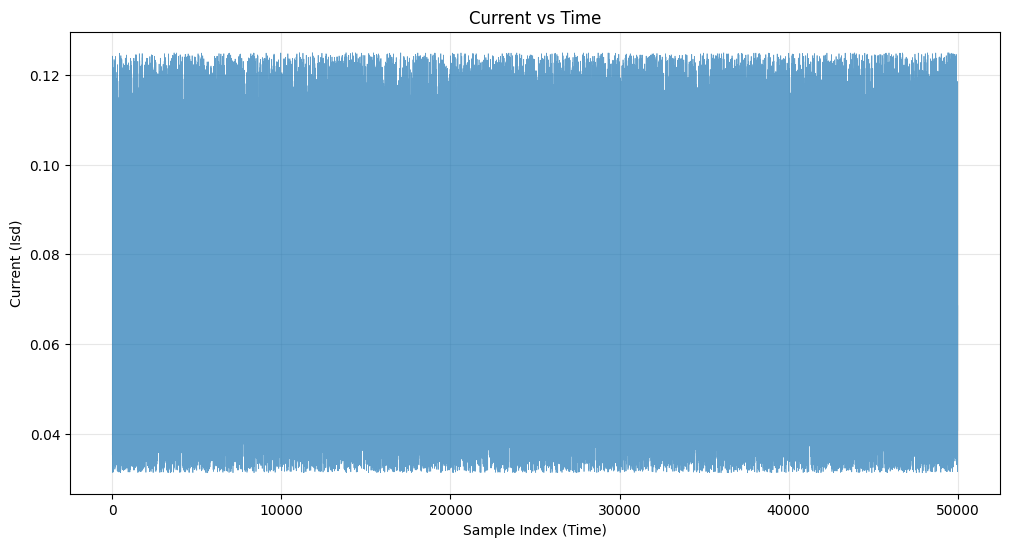

Total data points: 50000
At 50kHz sampling rate, this represents 1.00 seconds of data


In [18]:
# Plot current (Isd) over time
plt.figure(figsize=(12, 6))
plt.plot(data_1['Isd'], alpha=0.7, linewidth=0.5)
plt.xlabel('Sample Index (Time)')
plt.ylabel('Current (Isd)')
plt.title('Current vs Time')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total data points: {len(data_1)}")
print(f"At 50kHz sampling rate, this represents {len(data_1)/50000:.2f} seconds of data")

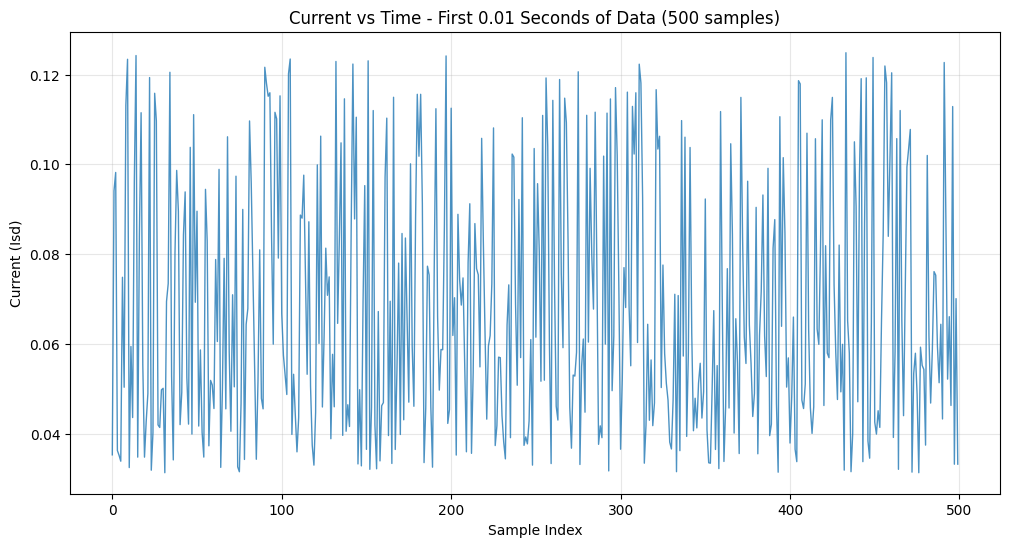

Plotting first 500 data points (0.01 seconds at 50kHz)


In [20]:
# Plot a 0.01-second sample (500 data points at 50kHz)
sample_rate = 50000  # Hz
sample_time = 0.01  # 0.01 seconds = 10 milliseconds
sample_points = int(sample_rate * sample_time)  # 500 points

# Take the first 0.01 seconds of data
sample_data = data_1['Isd'][:sample_points]

plt.figure(figsize=(12, 6))
plt.plot(sample_data, alpha=0.8, linewidth=1.0)
plt.xlabel('Sample Index')
plt.ylabel('Current (Isd)')
plt.title('Current vs Time - First 0.01 Seconds of Data (500 samples)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Plotting first {len(sample_data)} data points (0.01 seconds at 50kHz)")

## Signal Detection: Finding Molecular Events

Now let's identify when the molecule binds to the system by looking for step changes above the background noise level.

In [21]:
# Step 1: Define background period (first 15 minutes as mentioned)
# At 50kHz, 15 minutes = 15 * 60 * 50000 = 45,000,000 points
sample_rate = 50000  # Hz
background_time = 15 * 60  # 15 minutes in seconds
background_points = min(int(sample_rate * background_time), len(data_1))

# Extract background data
background_data = data_1['Isd'][:background_points]

# Calculate background statistics
background_mean = background_data.mean()
background_std = background_data.std()

print(f"Background period: first {background_points} points ({background_points/sample_rate:.1f} seconds)")
print(f"Background mean current: {background_mean:.2e}")
print(f"Background std deviation: {background_std:.2e}")
print(f"Signal threshold (mean + 3*std): {background_mean + 3*background_std:.2e}")

Background period: first 50000 points (1.0 seconds)
Background mean current: 7.04e-02
Background std deviation: 2.75e-02
Signal threshold (mean + 3*std): 1.53e-01


Points above threshold: 0 out of 50000 (0.00%)


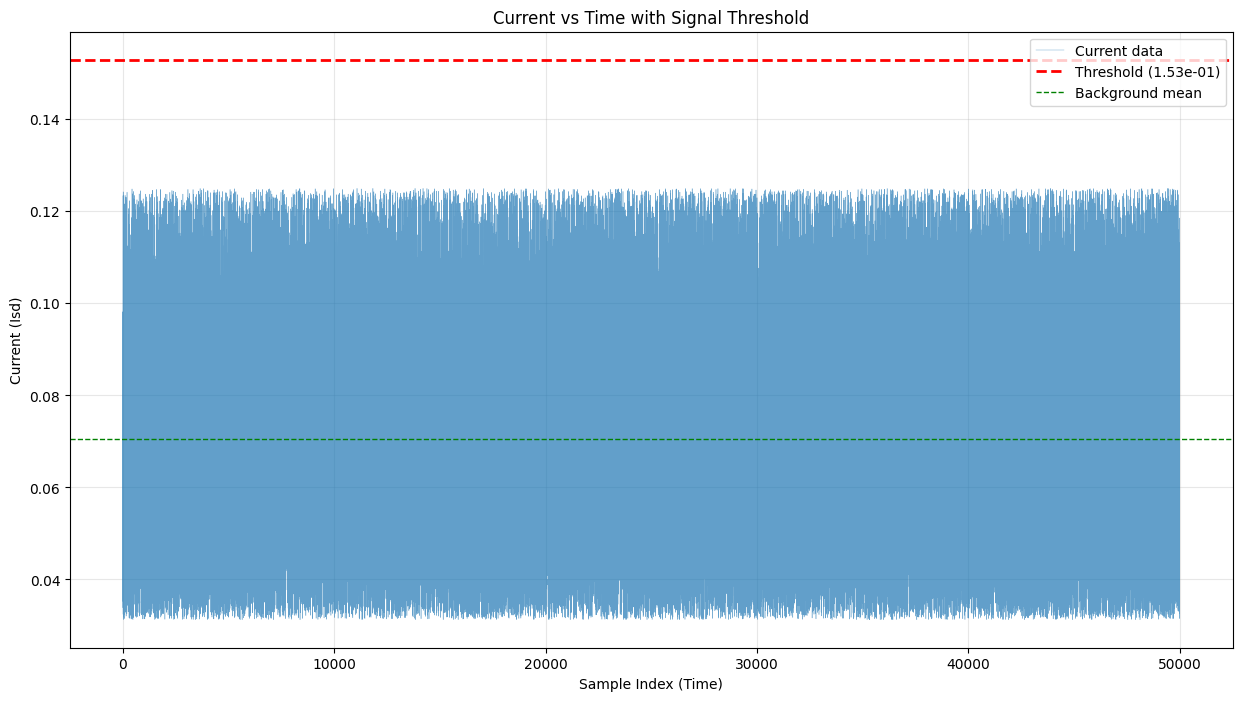

In [22]:
# Step 2: Detect significant deviations from background
# Define threshold for signal detection (typically 3-5 sigma above background)
threshold = background_mean + 3 * background_std

# Find points where signal exceeds threshold
signal_mask = data_1['Isd'] > threshold
signal_indices = data_1.index[signal_mask]

print(f"Points above threshold: {len(signal_indices)} out of {len(data_1)} ({100*len(signal_indices)/len(data_1):.2f}%)")

# Plot the full data with threshold line
plt.figure(figsize=(15, 8))
plt.plot(data_1['Isd'], alpha=0.7, linewidth=0.3, label='Current data')
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.2e})')
plt.axhline(y=background_mean, color='green', linestyle='--', linewidth=1, label=f'Background mean')
plt.xlabel('Sample Index (Time)')
plt.ylabel('Current (Isd)')
plt.title('Current vs Time with Signal Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()